In [1]:
import os
import textract
import re
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
en_stop = set(nltk.corpus.stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
resume_path = '/Users/Ketki/Documents/MS Theses/Reference Papers and Data/Selected/'
reference = '/Users/Ketki/Documents/MS Theses/Candidate list.xlsx'

In [3]:
def preprocessText(text, textEncoding = 'windows-1252'):
    text = re.sub(r'[^\x20-\x7e]',r' ', text.decode(encoding = textEncoding))
    return text

In [4]:
def getResumeReference(referencePath):
    refDataFrame = pd.read_excel(reference)
    return refDataFrame

In [5]:
def getResumeDataFrame(resumePath):
    resume_list = []
    r_file_list = []
    
    for file in os.listdir(resume_path):
        if file == '.DS_Store':
            continue
            
        filename = resume_path + file
        #print(filename)
        r_file_list.append(file)
        
        try:
            text = textract.process(filename)
            text = preprocessText(text, 'utf-8')
            resume_list.append(text)
        except Exception as se:
            print('{} -> {}'.format(file, se))
            
    resumeDataFrame = pd.DataFrame(list(zip(r_file_list,resume_list)), \
                             columns = ['res_name','res_contents'])
    refDataFrame = getResumeReference(reference)
    
    resumeDataFrame = resumeDataFrame.join(refDataFrame.set_index('res_name'),\
                                           on = 'res_name')
#    print(resumeDataFrame)
    return resumeDataFrame

In [6]:
def getNationalityDf(resumeDataFrame,countryName):
    nDataFrame = resumeDataFrame.loc[lambda resumeDataFrame: resumeDataFrame['nationality'] == countryName]
    nDataFrame = nDataFrame[['res_contents']]
    nDataFrame = nDataFrame.reset_index(drop=True)
    return nDataFrame

In [7]:
def unique_words(text):
    tokens_dict = {}
    text = str(text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [token.lower() for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if len(token) > 3]
    for word in tokens:
        if word in tokens_dict:
            continue
        else:
            tokens_dict[word] = 1
    return tokens_dict

In [8]:
def getDocFreq(tokens_dict, length):
    tokenDataFrame = pd.DataFrame.from_dict(tokens_dict, orient = 'index')
    valuePDataFrame = tokenDataFrame.div(length)
    return valuePDataFrame

In [9]:
def getRatioPercent(concatDf):
    concatDf = concatDf.fillna(0)
    ratioP = (concatDf.min(axis=1)/concatDf.max(axis=1))
    ratioDf = pd.DataFrame(ratioP)
    ratioDf = ratioDf.reset_index()
    ratioDf = ratioDf.rename(columns={'index':'words',0:'pRatio'})
    return ratioDf

In [10]:
def getTfidfFixed(resumeDataFrame,ratioDf,countryName):
    processDataFrame = resumeDataFrame.loc[lambda resumeDataFrame: resumeDataFrame['nationality'] == countryName]
    
    tfidf = TfidfVectorizer(stop_words = 'english', lowercase = True)
    tfidfMatrix = tfidf.fit_transform(processDataFrame['res_contents'])

    # Normalize the tf-idf vectors
    tfidfMatrix = normalize(tfidfMatrix)
    
    # get tfidf value for each word in a dataframe
    feature = tfidf.get_feature_names()
    matrixDf = pd.DataFrame(tfidfMatrix.toarray(), columns = feature)
    
    # multiply with computed p ratio
    for i in range(len(ratioDf)):
        try:
            temp = ratioDf['words'].iloc[i]
            matrixDf[temp] = matrixDf[temp]*ratioDf['pRatio'].iloc[i]
        except (KeyError):
            pass
    
    totalCount = matrixDf.select_dtypes(pd.np.number).sum()
    wordFreq = totalCount.to_dict()
    return wordFreq

In [11]:
def getWordCloud(wordFreq, countryName):
# generate tag cloud from frequencies i.e. word frequencies    
    wc = WordCloud(background_color = 'white',width = 1024,height = 720).generate_from_frequencies(wordFreq)
    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()
    path = '/Users/Ketki/Documents/MS Theses/Reference Papers and Data/Fig/' + countryName + '_new.png'
    wc.to_file(path)

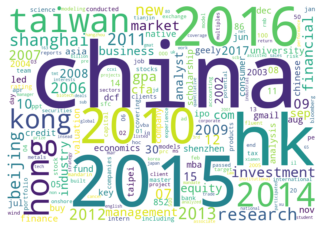

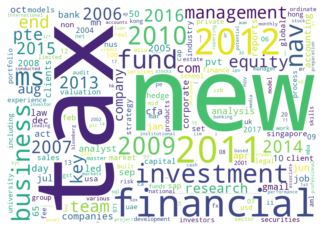

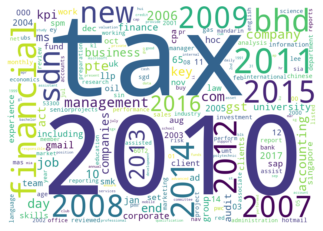

In [12]:
if __name__ == '__main__':
    dictionary = None
    country = ['China','India','Malaysia']
    concatDf = pd.DataFrame()
    resumeDataFrame = getResumeDataFrame(resume_path)
    
    for c in country:
        nDataFrame = getNationalityDf(resumeDataFrame, c)
        length = len(nDataFrame)
        for i in range(len(nDataFrame)):
    #    print(nDataFrame['res_contents'][0])
            dic = unique_words(nDataFrame['res_contents'][i])
            if dictionary == None:
                dictionary = dic
            else:
                for k in dic.keys():
                    if k in dictionary:
                        dictionary[k] += 1
                    else:
                        dictionary[k] = 1
    #    tokensDict = getTokensDict(nDataFrame)
        valuePDataFrame = getDocFreq(dictionary, length)
        concatDf = concatDf.merge(valuePDataFrame, left_index = True, right_index = True, how= 'outer')
        concatDf = concatDf.rename(columns={0:c})
    
    ratioDf = getRatioPercent(concatDf)
    for c in country:
        wordFreq = getTfidfFixed(resumeDataFrame, ratioDf, c)
        getWordCloud(wordFreq, c)